In [90]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from glob import glob
import pathlib
import common
import ujson as json

FONT_SIZE = 15
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title
matplotlib.rc('lines', linewidth=3)

In [145]:
def miss_decouple(df):
    v = json.loads(df.miss_decouple)
    misses = {i[0]: i[1][0]-i[1][1]   for i in v}
    requests = {i[0]: i[1][0]   for i in v}
    bins = np.arange(0, max(misses.keys())+1)
    ys = []
    for b in bins:
        if b in misses:
            ys.append({'bin_id': b, '#misses': misses[b], '#requests': requests[b]})
        else:
            ys.append({'bin_id': b, '#misses': 0, '#requests': 0})
    return pd.DataFrame.from_records(ys)

In [146]:
def cache_size_decouple(df, bin_id):
    v = json.loads(df.cache_size_decouple)
    sizes = {i[0][0]: i[1] for i in v if i[0][1] == bin_id}
    bins = np.arange(0, max(sizes.keys())+1)
    ys = []
    for b in bins:
        if b in a:
            ys.append({'bin_id': b, 'sizes': sizes[b]})
        else:
            ys.append({'bin_id': b, 'sizes': 0})
    return pd.DataFrame.from_records(ys)

In [147]:
trace = 'wc200m.tr'

df = common.load_reports()
filter_idx = (
    (df.trace_file == trace) 
    & (df.uni_size == 0)
    & ((df.cache_type != 'LRUK') | (df.k == '4'))
#     & (df.cache_type == 'LRUK')
#     & (df.cache_type == 'GDBT') 
#     & ((df.cache_type == 'GDBT') | (df.cache_type == 'LRUK'))
    & (df.cache_size == 384000000000)
    & (df.n_warmup == 80000000)
)

df1 = df[filter_idx].copy()

In [148]:
df2 = df1[~pd.isna(df1.miss_decouple)]

In [149]:
df2

,alpha,base_edwt_window,batch_size,bias_center,bias_point,byte_hit_rate,cache_size,cache_size_decouple,cache_type,cutoff,...,segment_window,simulation_time,static_window,threshold,trace_file,training_sample_interval,uni_size,version,window,zero_cost
7606,NaN,NaN,100000,NaN,NaN,0.737036,3.840000e+11,"[[[200,21],5350],[[200,19],2081],[[200,18],262...",GDBT,NaN,...,NaN,5579,NaN,NaN,wc200m.tr,64,0.0,double_penalty,NaN,NaN
7613,NaN,NaN,NaN,NaN,NaN,0.836491,3.840000e+11,"[[[200,21],5350],[[200,19],2081],[[200,18],262...",Belady,NaN,...,NaN,712,NaN,NaN,wc200m.tr,NaN,0.0,NaN,NaN,NaN


In [150]:
dfs = {
    'GDBT': df2.iloc[0],
    'Belady': df2.iloc[1],
} 

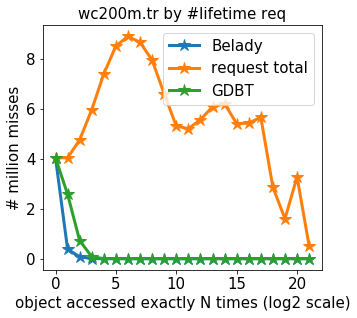

In [151]:
fig, ax = plt.subplots(figsize=(5, 4.5))
scale = 1000000
cache_types = ['Belady', 'GDBT']
for i, cache_type in enumerate(cache_types):
    df = miss_decouple(dfs[cache_type])
    ax.plot(
        df['bin_id'], 
        df['#misses']/scale, 
        label=cache_type,
        marker='*', 
        markersize=12,
    )
    if i == 0:
        ax.plot(
                df['bin_id'], 
                df['#requests']/scale, 
                label='request total',
                marker='*', 
                markersize=12,
        )
plt.legend()
plt.xlabel('object accessed exactly N times (log2 scale)')
plt.ylabel('# million misses')
plt.title(f'{trace} by #lifetime req')
plt.show()

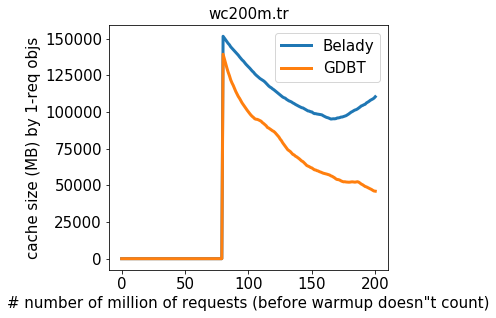

In [152]:
fig, ax = plt.subplots(figsize=(5, 4.5))
scale = 1000000
cache_types = ['Belady', 'GDBT']
for i, cache_type in enumerate(cache_types):
    df = cache_size_decouple(dfs[cache_type], 0)
    ax.plot(
        df['bin_id'], 
        df['sizes']/scale, 
        label=cache_type,
#         marker='*', 
#         markersize=12,
    )
plt.legend()
plt.xlabel('# number of million of requests (before warmup doesn"t count)')
plt.ylabel('cache size (MB) by 1-req objs')
plt.title(f'{trace}')
plt.show()

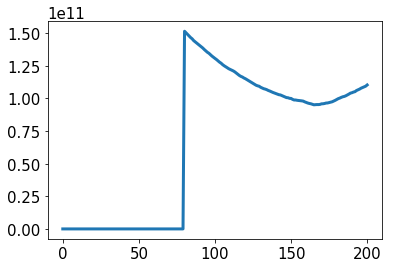

In [80]:
plt.plot(d.x, d.y)

In [ ]:
df1[df1.cache_type == 'GDBT'].tail(100)

In [216]:
df1[df1.version == 'reweight'][['byte_hit_rate', 'object_hit_rate', 'ohr_size_penalty_factor']].round(4)

,byte_hit_rate,object_hit_rate,ohr_size_penalty_factor
5363,0.6050,0.9611,10
5364,0.6525,0.9618,1.01
5365,0.6488,0.9618,1.1
5366,0.6143,0.9613,4
5367,0.6387,0.9617,1.4
5368,0.6519,0.9618,1.001
5369,0.6450,0.9617,1.2
5370,0.6282,0.9615,2
5373,0.7385,0.9491,NaN


In [217]:
df_r = df1[df1['byte_hit_rate'] == df1.groupby('cache_type')['byte_hit_rate'].transform(max)].sort_values('byte_hit_rate', ascending=False)

In [218]:
df_r[['cache_type', 'byte_hit_rate']].round(4)

,cache_type,byte_hit_rate
4073,Inf,0.8510
4105,Belady,0.8365
4924,BeladySample,0.8315
5346,GDBT,0.7472
4770,Adaptive-TinyLFU,0.7467
4095,LFUDA,0.7243
4107,LRUK,0.7226
4504,LeCaR,0.7075
4135,LR,0.7055
4079,LRU,0.7014


In [ ]:
df_r.loc[]

In [81]:
df_r = df1[df1['object_hit_rate'] == df1.groupby('cache_type')['object_hit_rate'].transform(max)].sort_values('object_hit_rate', ascending=False)

In [82]:
df_r[['cache_type', 'object_hit_rate']].round(3)

,cache_type,object_hit_rate
4073,Inf,0.966
4149,GDSF,0.964
4800,LR,0.963
4697,LHD,0.963
4105,Belady,0.963
4791,GDBT,0.962
4924,BeladySample,0.961
4726,GDWheel,0.956
4770,Adaptive-TinyLFU,0.942
4523,AdaptSize,0.942


In [83]:
# df_gdbt = [float(i) for i in df1.loc[3838].segment_byte_hit_rate.split('\t')[:-1]]
# df_lruk = [float(i) for i in df1.loc[3690].segment_byte_hit_rate.split('\t')[:-1]]
# fig, ax = plt.subplots(figsize=(12, 8))
# plt.plot(df_gdbt, marker='*', label='gdbt')
# plt.plot(df_lruk, marker='*', label='lruk')
# plt.legend()
# plt.xlabel('segment id')
# plt.ylabel('hit rate')
# plt.title('segment byte hit rate for wiki trace, segment window = 1m requests')
# plt.ylim([0, 1.])
# plt.show()

In [194]:
trace = 'memc_200m.tr'

df = common.load_reports()
filter_idx = (
    (df.trace_file == trace) 
    & (df.uni_size == 0)
#     & ((df.cache_type == 'GDBT') | (df.cache_type == 'LRUK'))
#     & ((df.cache_type == 'Belady') | (df.cache_type == 'BeladySample'))
    & (df.cache_size == 4000000000)
    & (df.n_warmup == 20000000)
)

df1 = df[filter_idx].copy()

In [86]:
df1[df1.version == 'reweight'][['byte_hit_rate', 'object_hit_rate', 'ohr_size_penalty_factor']].round(4)

,byte_hit_rate,object_hit_rate,ohr_size_penalty_factor
5368,0.9438,0.9268,NaN
5379,0.9080,0.9450,10
5380,0.9102,0.9457,4
5382,0.9167,0.9470,1.4
5383,0.9137,0.9465,2
5397,0.9181,0.9472,1.2
5398,0.9200,0.9475,1.001
5399,0.9200,0.9475,1.01
5400,0.9192,0.9474,1.1


In [87]:
df1[df1.version == 'hashed_pow']

,alpha,batch_size,bias_center,bias_point,byte_hit_rate,cache_size,cache_type,cutoff,dead_penalty,gradient_window,...,segment_window,simulation_time,static_window,threshold,trace_file,training_sample_interval,uni_size,version,window,zero_cost
5349,NaN,NaN,NaN,NaN,0.944408,4.000000e+09,GDBT,NaN,NaN,100000,...,NaN,4032,NaN,10000000,memc_200m.tr,64,0.0,hashed_pow,NaN,NaN


In [114]:
df_r = df1[df1['byte_hit_rate'] == df1.groupby('cache_type')['byte_hit_rate'].transform(max)]\
            .drop_duplicates('cache_type').sort_values('byte_hit_rate', ascending=False)

In [115]:
df_r[['cache_type', 'byte_hit_rate']].round(3)

,cache_type,byte_hit_rate
4384,Inf,0.966
4399,Belady,0.963
4939,BeladySample,0.962
5331,GDBT,0.946
4762,Adaptive-TinyLFU,0.944
4489,LeCaR,0.943
4385,LRU,0.942
4395,LR,0.942
4394,LFUDA,0.937
4387,S4LRU,0.936


In [90]:
df_r = df1[df1['object_hit_rate'] == df1.groupby('cache_type')['object_hit_rate'].transform(max)].sort_values('object_hit_rate', ascending=False)

In [91]:
df_r[['cache_type', 'object_hit_rate']].round(3)

,cache_type,object_hit_rate
4384,Inf,0.958
4399,Belady,0.954
4939,BeladySample,0.953
4397,GDSF,0.950
5319,GDBT,0.948
4703,LHD,0.946
4821,LR,0.945
4736,GDWheel,0.945
4510,AdaptSize,0.934
4762,Adaptive-TinyLFU,0.931


In [95]:
# df_gdbt = [float(i) for i in df.loc[3844].segment_byte_hit_rate.split('\t')[:-1]]
# df_lruk = [float(i) for i in df.loc[3735].segment_byte_hit_rate.split('\t')[:-1]]
# fig, ax = plt.subplots(figsize=(12, 8))
# plt.plot(df_gdbt, marker='*', label='gdbt')
# plt.plot(df_lruk, marker='*', label='lruk')
# plt.legend()
# plt.xlabel('segment id')
# plt.ylabel('hit rate')
# plt.title('segment byte hit rate for wiki trace, segment window = 1m requests')
# plt.ylim([0, 1.])
# plt.show()

In [180]:
819200000000/1e9

819.2

In [222]:
trace = 'msr_big_200m.tr'

df = common.load_reports()
filter_idx = (
    (df.trace_file == trace) 
    & (df.uni_size == 0)
#     & ((df.cache_type == 'Belady') | (df.cache_type == 'BeladySample'))
#         & (df.cache_type == 'GDBT')
    & (df.cache_size == 819200000000)
    & (df.n_warmup == 100000000)
)

df1 = df[filter_idx].copy()

In [221]:
df1[df1.cache_type == 'GDBT'].tail()

,alpha,base_edwt_window,batch_size,bias_center,bias_point,byte_hit_rate,cache_size,cache_type,cutoff,dead_penalty,...,segment_window,simulation_time,static_window,threshold,trace_file,training_sample_interval,uni_size,version,window,zero_cost
6550,NaN,NaN,100000,NaN,NaN,0.818110,8.192000e+11,GDBT,NaN,NaN,...,NaN,3412,NaN,NaN,msr_big_200m.tr,64,0.0,double_penalty,NaN,NaN
6551,NaN,NaN,100000,NaN,NaN,0.823358,8.192000e+11,GDBT,NaN,NaN,...,NaN,3445,NaN,NaN,msr_big_200m.tr,64,0.0,double_penalty,NaN,NaN
6553,NaN,NaN,100000,NaN,NaN,0.799187,8.192000e+11,GDBT,NaN,NaN,...,NaN,3891,NaN,NaN,msr_big_200m.tr,64,0.0,double_penalty,NaN,NaN
6556,NaN,NaN,100000,NaN,NaN,0.811211,8.192000e+11,GDBT,NaN,NaN,...,NaN,4130,NaN,NaN,msr_big_200m.tr,64,0.0,double_penalty,NaN,NaN
6562,NaN,NaN,100000,NaN,NaN,0.796588,8.192000e+11,GDBT,NaN,NaN,...,NaN,4389,NaN,NaN,msr_big_200m.tr,64,0.0,double_penalty,NaN,NaN


In [179]:
df1[(df1.cache_type == 'GDBT') & (df1.version == 'reduce_lru')]

,alpha,batch_size,bias_center,bias_point,byte_hit_rate,cache_size,cache_type,cutoff,dead_penalty,gradient_window,...,segment_window,simulation_time,static_window,threshold,trace_file,training_sample_interval,uni_size,version,window,zero_cost
5579,NaN,NaN,NaN,NaN,0.793984,8.192000e+11,GDBT,NaN,NaN,400000,...,NaN,3163,NaN,80000000,msr_big_200m.tr,64,0.0,reduce_lru,NaN,NaN
5580,NaN,NaN,NaN,NaN,0.793984,8.192000e+11,GDBT,NaN,NaN,400000,...,NaN,2561,NaN,80000000,msr_big_200m.tr,64,0.0,reduce_lru,NaN,NaN
5581,NaN,NaN,NaN,NaN,0.791875,8.192000e+11,GDBT,NaN,NaN,400000,...,NaN,2654,NaN,80000000,msr_big_200m.tr,64,0.0,reduce_lru,NaN,NaN
5582,NaN,NaN,NaN,NaN,0.783885,8.192000e+11,GDBT,NaN,NaN,400000,...,NaN,3387,NaN,80000000,msr_big_200m.tr,64,0.0,reduce_lru,NaN,NaN
5583,NaN,NaN,NaN,NaN,0.793074,8.192000e+11,GDBT,NaN,NaN,400000,...,NaN,3212,NaN,80000000,msr_big_200m.tr,64,0.0,reduce_lru,NaN,NaN
5584,NaN,NaN,NaN,NaN,0.652056,8.192000e+11,GDBT,NaN,NaN,400000,...,NaN,3663,NaN,80000000,msr_big_200m.tr,64,0.0,reduce_lru,NaN,NaN
5585,NaN,NaN,NaN,NaN,0.652147,8.192000e+11,GDBT,NaN,NaN,400000,...,NaN,3407,NaN,80000000,msr_big_200m.tr,64,0.0,reduce_lru,NaN,NaN
5586,NaN,NaN,NaN,NaN,0.652115,8.192000e+11,GDBT,NaN,NaN,400000,...,NaN,3661,NaN,80000000,msr_big_200m.tr,64,0.0,reduce_lru,NaN,NaN
5587,NaN,NaN,NaN,NaN,0.791875,8.192000e+11,GDBT,NaN,NaN,400000,...,NaN,3097,NaN,80000000,msr_big_200m.tr,64,0.0,reduce_lru,NaN,NaN
5588,NaN,NaN,NaN,NaN,0.782288,8.192000e+11,GDBT,NaN,NaN,400000,...,NaN,3467,NaN,80000000,msr_big_200m.tr,64,0.0,reduce_lru,NaN,NaN


In [171]:
df1[(df1.cache_type == 'GDBT') & (df1.version == 'lr_like')].max()

alpha                                                                    None
batch_size                                                               None
bias_center                                                              None
bias_point                                                               None
byte_hit_rate                                                        0.803729
cache_size                                                          8.192e+11
cache_type                                                               GDBT
cutoff                                                                   None
dead_penalty                                                             None
gradient_window                                                        400000
k                                                                        None
label                       cache_type: GDBT gradient_window: 400000 learn...
learning_rate                                                   

In [172]:
df1[(df1.cache_type == 'GDBT') & (df1.version == 'lr_distance')]

,alpha,batch_size,bias_center,bias_point,byte_hit_rate,cache_size,cache_type,cutoff,dead_penalty,gradient_window,...,segment_window,simulation_time,static_window,threshold,trace_file,training_sample_interval,uni_size,version,window,zero_cost
5549,NaN,NaN,NaN,NaN,0.802163,8.192000e+11,GDBT,NaN,NaN,400000,...,NaN,1711,NaN,80000000,msr_big_200m.tr,64,0.0,lr_distance,NaN,NaN
5550,NaN,NaN,NaN,NaN,0.806934,8.192000e+11,GDBT,NaN,NaN,400000,...,NaN,1723,NaN,80000000,msr_big_200m.tr,64,0.0,lr_distance,NaN,NaN
5551,NaN,NaN,NaN,NaN,0.803698,8.192000e+11,GDBT,NaN,NaN,400000,...,NaN,1879,NaN,80000000,msr_big_200m.tr,64,0.0,lr_distance,NaN,NaN
5552,NaN,NaN,NaN,NaN,0.806437,8.192000e+11,GDBT,NaN,NaN,400000,...,NaN,1954,NaN,80000000,msr_big_200m.tr,64,0.0,lr_distance,NaN,NaN
5553,NaN,NaN,NaN,NaN,0.805290,8.192000e+11,GDBT,NaN,NaN,400000,...,NaN,2029,NaN,80000000,msr_big_200m.tr,64,0.0,lr_distance,NaN,NaN
5554,NaN,NaN,NaN,NaN,0.800853,8.192000e+11,GDBT,NaN,NaN,400000,...,NaN,2071,NaN,80000000,msr_big_200m.tr,64,0.0,lr_distance,NaN,NaN
5555,NaN,NaN,NaN,NaN,0.801294,8.192000e+11,GDBT,NaN,NaN,400000,...,NaN,2195,NaN,80000000,msr_big_200m.tr,64,0.0,lr_distance,NaN,NaN
5556,NaN,NaN,NaN,NaN,0.804229,8.192000e+11,GDBT,NaN,NaN,400000,...,NaN,2177,NaN,80000000,msr_big_200m.tr,64,0.0,lr_distance,NaN,NaN
5557,NaN,NaN,NaN,NaN,0.797882,8.192000e+11,GDBT,NaN,NaN,400000,...,NaN,2211,NaN,80000000,msr_big_200m.tr,64,0.0,lr_distance,NaN,NaN
5558,NaN,NaN,NaN,NaN,0.800858,8.192000e+11,GDBT,NaN,NaN,400000,...,NaN,2224,NaN,80000000,msr_big_200m.tr,64,0.0,lr_distance,NaN,NaN


In [173]:
df2 = df1[(df1.cache_type == 'GDBT') & (df1.version == 'lr_like') & (df1.num_threads == '2')]
pd.pivot_table(df2, index='n_gradient_window', columns=['num_iterations', 'objective'], values='byte_hit_rate').round(4)

num_iterations               10                            12                  \
objective         byte_hit_rate object_hit_rate byte_hit_rate object_hit_rate   
n_gradient_window                                                               
1                        0.7903          0.8009        0.7864          0.8001   
2                        0.7944          0.7986        0.7916          0.8001   
4                        0.7915          0.7987        0.7903          0.7970   
6                        0.7891          0.7937        0.7909          0.7924   
8                        0.7829          0.7892        0.7833          0.7877   

num_iterations                4                             6                  \
objective         byte_hit_rate object_hit_rate byte_hit_rate object_hit_rate   
n_gradient_window                                                               
1                        0.7963          0.8037        0.7927          0.8016   
2                        0.7966          0.7999        0.7927          0.7985   
4                        0.7943          0.8031        0.7933          0.7981   
6                        0.7941          0.8020        0.7873          0.7969   
8                        0.7947          0.8023        0.7896          0.7934   

num_iterations                8                  
objective         byte_hit_rate object_hit_rate  
n_gradient_window                                
1                        0.7913          0.8006  
2                        0.7907          0.7996  
4                        0.7914          0.7977  
6                        0.7886          0.7967  
8                        0.7875          0.7931

In [174]:
df2 = df1[(df1.cache_type == 'GDBT') & (df1.version == 'lr_like') & (df1.num_threads == '1')]
pd.pivot_table(df2, index='n_gradient_window', columns=['num_iterations', 'objective'], values='byte_hit_rate').round(4)

num_iterations                1                             2                  \
objective         byte_hit_rate object_hit_rate byte_hit_rate object_hit_rate   
n_gradient_window                                                               
1                        0.7421          0.7570        0.7798          0.7972   
2                        0.7355          0.7495        0.7840          0.7959   
4                        0.7445          0.7522        0.7935          0.8000   
6                        0.7445          0.7546        0.7931          0.7975   
8                        0.7319          0.7399        0.7897          0.7888   

num_iterations                4                  
objective         byte_hit_rate object_hit_rate  
n_gradient_window                                
1                        0.8004          0.8021  
2                        0.7901          0.7989  
4                        0.7925          0.8008  
6                        0.7895          0.7953  
8                        0.7917          0.7901

In [175]:
df1[df1.version == 'reweight'][['byte_hit_rate', 'object_hit_rate', 'ohr_size_penalty_factor']].round(4)

,byte_hit_rate,object_hit_rate,ohr_size_penalty_factor
5371,0.7923,0.8740,NaN
5401,0.8038,0.8956,1.4
5402,0.8033,0.8953,1.2
5403,0.8034,0.8954,1.1
5404,0.8039,0.8956,1.001
5445,0.8025,0.8951,10
5446,0.8021,0.8949,4
5447,0.8037,0.8956,2
5448,0.8032,0.8954,1.01


In [202]:
df_r = df1[df1['byte_hit_rate'] == df1.groupby('cache_type')['byte_hit_rate'].transform(max)]\
            .drop_duplicates('cache_type').sort_values('byte_hit_rate', ascending=False)

In [205]:
df_r[['cache_type', 'byte_hit_rate']].round(3)

,cache_type,byte_hit_rate
4183,Inf,0.892
4201,Belady,0.892
4981,BeladySample,0.871
4760,Adaptive-TinyLFU,0.836
4835,LR,0.833
6007,GDBT,0.832
4740,GDWheel,0.827
4718,LHD,0.822
4494,LeCaR,0.809
4257,GDSF,0.803


In [204]:
df.loc[6007]

alpha                                                                     NaN
batch_size                                                             100000
bias_center                                                               NaN
bias_point                                                                NaN
byte_hit_rate                                                        0.831963
cache_size                                                          8.192e+11
cache_type                                                               GDBT
cutoff                                                                    NaN
dead_penalty                                                              NaN
forget_window                                                       120000000
gradient_window                                                           NaN
k                                                                         NaN
label                       cache_type: GDBT batch_size: 100000 

In [178]:
df_r.loc[5550]

alpha                                                                     NaN
batch_size                                                                NaN
bias_center                                                               NaN
bias_point                                                                NaN
byte_hit_rate                                                        0.806934
cache_size                                                          8.192e+11
cache_type                                                               GDBT
cutoff                                                                    NaN
dead_penalty                                                              NaN
gradient_window                                                        400000
k                                                                         NaN
label                       cache_type: GDBT gradient_window: 400000 learn...
learning_rate                                                   

In [119]:
df.loc[4835]

alpha                                                                     NaN
batch_size                                                                NaN
bias_center                                                               NaN
bias_point                                                                NaN
byte_hit_rate                                                        0.832651
cache_size                                                          8.192e+11
cache_type                                                                 LR
cutoff                                                                    NaN
dead_penalty                                                              NaN
gradient_window                                                       1000000
k                                                                         NaN
label                       cache_type: LR gradient_window: 1000000 learni...
learning_rate                                                   

In [102]:
df_r = df1[df1['object_hit_rate'] == df1.groupby('cache_type')['object_hit_rate'].transform(max)].sort_values('object_hit_rate', ascending=False)

In [103]:
df_r[['cache_type', 'object_hit_rate']].round(3)

,cache_type,object_hit_rate
4183,Inf,0.944
4201,Belady,0.944
4981,BeladySample,0.930
4835,LR,0.919
4760,Adaptive-TinyLFU,0.914
4718,LHD,0.913
4740,GDWheel,0.912
4257,GDSF,0.899
5404,GDBT,0.896
4494,LeCaR,0.878


In [104]:
# fig, ax = plt.subplots(figsize=(12, 8))
# plt.plot(df_gdbt, marker='*', label='gdbt')
# plt.plot(df_lruk, marker='*', label='lruk')
# plt.legend()
# plt.xlabel('segment id')
# plt.ylabel('hit rate')
# plt.title('segment byte hit rate for wiki trace, segment window = 1m requests')
# plt.ylim([0, 1.])
# plt.show()

In [105]:
trace = 'anonymous_200m.tr'

df = common.load_reports()
filter_idx = (
    (df.trace_file == trace) 
    & (df.uni_size == 0)
#     & (df.cache_type == 'GDBT') 
#     & ((df.cache_type == 'GDBT') | (df.cache_type == 'LRUK'))
    & (df.cache_size == 16000000000)
    & (df.n_warmup == 20000000)
)

df1 = df[filter_idx].copy()

In [106]:
df1[df1.version == 'reweight'][['byte_hit_rate', 'object_hit_rate']].round(4)

,byte_hit_rate,object_hit_rate
5367,0.9693,0.9374
5420,0.9139,0.9357
5422,0.9162,0.9382
5423,0.9218,0.9414
5424,0.9390,0.9454
5425,0.9458,0.9462
5426,0.9456,0.9462
5427,0.9327,0.9442
5428,0.9425,0.9458


In [107]:
df_r = df1[df1['byte_hit_rate'] == df1.groupby('cache_type')['byte_hit_rate'].transform(max)]\
            .drop_duplicates('cache_type').sort_values('byte_hit_rate', ascending=False)

In [108]:
df_r[['cache_type', 'byte_hit_rate']].round(3)

,cache_type,byte_hit_rate
3968,Inf,0.993
4014,Belady,0.981
3986,BeladySample,0.979
5072,GDBT,0.970
4268,LR,0.968
4007,LFUDA,0.966
4482,LeCaR,0.966
3971,LRU,0.965
4763,Adaptive-TinyLFU,0.965
3980,S4LRU,0.956


In [109]:
df_r = df1[df1['object_hit_rate'] == df1.groupby('cache_type')['object_hit_rate'].transform(max)].sort_values('object_hit_rate', ascending=False)

In [110]:
df_r[['cache_type', 'object_hit_rate']].round(3)

,cache_type,object_hit_rate
3968,Inf,0.970
4014,Belady,0.952
3986,BeladySample,0.951
4286,GDSF,0.949
4716,LHD,0.946
4849,GDBT,0.946
4268,LR,0.938
4512,AdaptSize,0.937
4007,LFUDA,0.936
4482,LeCaR,0.936


In [111]:
trace = 'caida_cache_200m.tr'

df = common.load_reports()
filter_idx = (
    (df.trace_file == trace) 
    & (df.uni_size == 0)
#     & (df.cache_type == 'GDBT') 
#     & ((df.cache_type == 'GDBT') | (df.cache_type == 'LRUK'))
    & (df.cache_size == 8000000)
    & (df.n_warmup == 20000000)
)

df1 = df[filter_idx].copy()

In [112]:
df1[df1.version == 'reweight'][['byte_hit_rate', 'object_hit_rate']].round(4)

,byte_hit_rate,object_hit_rate
5370,0.9423,0.9423
5429,0.9423,0.9423
5430,0.9423,0.9423
5431,0.9423,0.9423
5432,0.9423,0.9423
5433,0.9423,0.9423
5434,0.9423,0.9423
5435,0.9423,0.9423
5440,0.9423,0.9423


In [49]:
df1[df1.version == 'hashed_pow']

,alpha,batch_size,bias_center,bias_point,byte_hit_rate,cache_size,cache_type,cutoff,dead_penalty,gradient_window,...,segment_window,simulation_time,static_window,threshold,trace_file,training_sample_interval,uni_size,version,window,zero_cost
5354,NaN,NaN,NaN,NaN,0.942252,8000000.0,GDBT,NaN,NaN,100000,...,NaN,5710,NaN,10000000,caida_cache_200m.tr,64,0.0,hashed_pow,NaN,NaN


In [28]:
df_r = df1[df1['byte_hit_rate'] == df1.groupby('cache_type')['byte_hit_rate'].transform(max)].sort_values('byte_hit_rate', ascending=False).drop_duplicates('cache_type')

In [29]:
df_r[['cache_type', 'byte_hit_rate']].round(3)

,cache_type,byte_hit_rate
4396,Inf,0.972
4411,Belady,0.957
4910,BeladySample,0.957
5346,GDBT,0.943
4768,Adaptive-TinyLFU,0.935
4486,LeCaR,0.935
4403,LRU,0.935
4443,S4LRU,0.930
4450,LR,0.925
4721,GDWheel,0.924


In [31]:
df_r = df1[df1['object_hit_rate'] == df1.groupby('cache_type')['object_hit_rate'].transform(max)].sort_values('object_hit_rate', ascending=False).drop_duplicates('cache_type')